In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


import tensorflow as tf
import keras.backend as K


%matplotlib inline

In [5]:
plt.style.use('ggplot')

In [6]:
f = r'C:\Users\mattk\code\Mkt_Data\all_futures.csv'
df = pd.read_csv(f,index_col=0,parse_dates=[0])
df = df.resample('1B').last()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13112 entries, 1970-03-30 to 2020-06-30
Freq: B
Data columns (total 38 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   AEX      2790 non-null   float64
 1   AUD      8423 non-null   float64
 2   BOBL     3191 non-null   float64
 3   BTP      2680 non-null   float64
 4   BUND     3513 non-null   float64
 5   CAC      2877 non-null   float64
 6   COPPER   6331 non-null   float64
 7   CORN     12248 non-null  float64
 8   CRUDE_W  7868 non-null   float64
 9   EDOLLAR  9262 non-null   float64
 10  EUR      5328 non-null   float64
 11  EUROSTX  1566 non-null   float64
 12  GAS_US   7560 non-null   float64
 13  GBP      11327 non-null  float64
 14  GOLD     11411 non-null  float64
 15  JPY      10932 non-null  float64
 16  KOSPI    1532 non-null   float64
 17  KR10     1520 non-null   float64
 18  KR3      1515 non-null   float64
 19  LEANHOG  11856 non-null  float64
 20  LIVECOW  12537 non-null  

In [7]:
assets = ['AUD', 'COPPER', 'CORN', 'CRUDE_W',
       'EDOLLAR', 'EUR', 'GAS_US', 'GBP', 'GOLD', 'JPY',
       'LEANHOG', 'LIVECOW', 'MXP', 'NASDAQ',
       'PALLAD', 'PLAT', 'SOYBEAN', 'SP500', 'US10', 'US2',
       'US20', 'US5', 'WHEAT']

In [ ]:
assets = ['COPPER', 'CORN', 'CRUDE_W','GOLD','SP500', 'US10']

In [8]:
df2 = df[assets].loc['1/1/2000':'1/1/2020']

In [9]:
def calc_macd(ser,s=8,l=24):
    '''
    input = series
    
    '''
    x = ser.ewm(span=(2*s-1)).mean() - ser.ewm(span=(2*l-1)).mean()
    y = x/ser.diff().ewm(span=25).std()
    y = y/y.rolling(252).std()
    return y

def get_feat_ret(asset,df):
    df3 = df.copy(deep=True)
    df3 = df3[[asset]]
    df3.fillna(method = 'ffill',inplace=True)
    df3['dif'] = df3[asset].diff()
    df3.dropna(inplace=True)
    
    tgt_vol = .15/np.sqrt(252)
    
    df3['macd1'] = calc_macd(df3[asset])
    df3['macd2'] = calc_macd(df3[asset],16,48)
    df3['macd3'] = calc_macd(df3[asset],32,96)
    df3['trend1'] = (df3[asset] - df3[asset].shift(1))/(df3[asset].diff().ewm(span=25).std()) # 1d
    df3['trend2'] = (df3[asset] - df3[asset].shift(21))/(df3[asset].diff().ewm(span=25).std()*np.sqrt(21)) # 1m
    df3['trend3'] = (df3[asset] - df3[asset].shift(63))/(df3[asset].diff().ewm(span=25).std()*np.sqrt(63)) # 3m
    df3['trend4'] = (df3[asset] - df3[asset].shift(126))/(df3[asset].diff().ewm(span=25).std()*np.sqrt(126)) # 6m
    df3['trend5'] = (df3[asset] - df3[asset].shift(252))/(df3[asset].diff().ewm(span=25).std()*np.sqrt(252)) # 1y
    
    #extra features
#     df3['mom'] = (df3['dif']*tgt_vol/df3['dif'].ewm(span=25).std()).rolling(60).apply(momentum)

    # df3['scaled_return_next'] = (df3[asset].diff()).shift(-1) # no vol scaling
    df3['scaled_return_next'] = (df3['dif']*tgt_vol/df3['dif'].ewm(span=25).std()).shift(-1)

    df3.dropna(inplace=True)
    
    feat = df3[['macd1','macd2','macd3','trend1','trend2','trend3','trend4','trend5']]
    ret = df3[['scaled_return_next']]
    
    return feat,ret

In [10]:
asset = 'GOLD'
df3 = get_feat_ret(asset,df2)

In [11]:
df3[1].head()

,scaled_return_next
DATETIME,
2000-12-25,0.002489
2000-12-26,0.006407
2000-12-27,-0.017754
2000-12-28,-0.000577
2000-12-29,0.000000


In [12]:
x = []
y = []
for a in assets:
    d = get_feat_ret(a,df2)
    x.append(d[0])
    y.append(d[1])

In [13]:
x = pd.concat(x,axis=1)
x.dropna(inplace=True)

y =pd.concat(y,axis=1)
y.columns = assets
y.dropna(inplace=True)

In [14]:
xtrain,xtest = x['2009':'2012'],x['2013':'2016']
ytrain,ytest = y['2009':'2012'], y['2013':'2016']

scalerX = StandardScaler()

xtrain_sc = pd.DataFrame(scalerX.fit_transform(xtrain.to_numpy()),columns=xtrain.columns,index=xtrain.index)
xtest_sc = pd.DataFrame(scalerX.transform(xtest.to_numpy()),columns=xtest.columns,index=xtest.index)

In [15]:
### Long only
out = ytest.mean(axis=1)
print('Return: {}'.format(out.mean()*252))
print('Vol: {}'.format(out.std()*np.sqrt(252)))
print('Sharpe: {}'.format(out.mean()*np.sqrt(252)/out.std()))

Return: -0.02999918491362075
Vol: 0.05889923494861386
Sharpe: -0.5093306379920434


In [16]:
### Linear Regression
lm = LinearRegression()
lm.fit(xtrain_sc,ytrain)
preds = lm.predict(xtest_sc)
pos = np.sign(preds)
out = (pos*ytest).mean(axis=1)
print('Return: {}'.format(out.mean()*252))
print('Vol: {}'.format(out.std()*np.sqrt(252)))
print('Sharpe: {}'.format(out.mean()*np.sqrt(252)/out.std()))

Return: -0.030463574507385564
Vol: 0.04883898526895059
Sharpe: -0.6237552713191361


In [17]:
def lstm_data_transform(x_data, y_data, num_steps=10):
    """ Changes data to the format for LSTM training 
    for sliding window approach """
    # Prepare the list for the transformed data
    X, y = list(), list()
    # Loop of the entire data set
    for i in range(x_data.shape[0]):
        # compute a new (sliding window) index
        end_ix = i + num_steps
        # if index is larger than the size of the dataset, we stop
        if end_ix >= x_data.shape[0]:
            break
        # Get a sequence of data for x
        seq_X = x_data[i:end_ix]
        # Get only the last element of the sequency for y
        seq_y = y_data[end_ix]
        # Append the list with sequencies
        X.append(seq_X)
        y.append(seq_y)
    # Make final arrays
    x_array = np.array(X)
    y_array = np.array(y)
    return x_array, y_array

In [18]:
num_steps = 40

t_xtrain_sc, t_ytrain = lstm_data_transform(xtrain_sc.to_numpy(),ytrain.to_numpy(),num_steps = num_steps)
t_xtest_sc, t_ytest = lstm_data_transform(xtest_sc.to_numpy(),ytest.to_numpy(), num_steps = num_steps)

In [29]:
### Returns Loss
model = tf.keras.Sequential([
    tf.keras.Input(shape=(num_steps, t_xtrain_sc.shape[2])),
    tf.keras.layers.LSTM(10,dropout=.1,recurrent_dropout=.1),
    tf.keras.layers.Dense(t_ytrain.shape[1],activation='tanh')
])
model.compile(loss=returnsLoss, optimizer=tf.optimizers.Adam(learning_rate=.001))

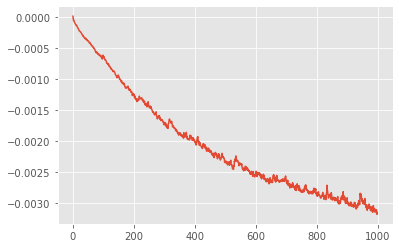

In [30]:
history = model.fit(t_xtrain_sc, t_ytrain, epochs=1000,verbose=0,batch_size=int(len(t_xtrain_sc)/5))
plt.plot(history.history['loss'])

In [31]:
preds_lstm  = model.predict(t_xtest_sc)
# pos_lstm = np.sign(preds_lstm)
pos_lstm = preds_lstm
out_lstm = (t_ytest*pos_lstm).mean(axis=1)
print('Return: {}'.format(out_lstm.mean()*252))
print('Vol: {}'.format(out_lstm.std()*np.sqrt(252)))
print('Sharpe: {}'.format(out_lstm.mean()*np.sqrt(252)/out_lstm.std()))

Return: -0.012858787975988778
Vol: 0.05084172337303751
Sharpe: -0.25291801935274444


In [32]:
### Sharpe Loss
model = tf.keras.Sequential([
    tf.keras.Input(shape=(num_steps, t_xtrain_sc.shape[2])),
#     tf.keras.layers.LSTM(10,dropout=.1,recurrent_dropout=.1),
    tf.keras.layers.LSTM(10),
    tf.keras.layers.Dense(t_ytrain.shape[1],activation='tanh')
])
model.compile(loss=sharpeLoss, optimizer=tf.optimizers.Adam(learning_rate=.001))

Epoch 1/1000
5/5 [==============================] - 0s 23ms/step - loss: -0.0232
Epoch 2/1000
5/5 [==============================] - 0s 25ms/step - loss: -0.2577
Epoch 3/1000
5/5 [==============================] - 0s 22ms/step - loss: -0.3686
Epoch 4/1000
5/5 [==============================] - 0s 23ms/step - loss: -0.4453
Epoch 5/1000
5/5 [==============================] - 0s 22ms/step - loss: -0.5041
Epoch 6/1000
5/5 [==============================] - 0s 22ms/step - loss: -0.5387
Epoch 7/1000
5/5 [==============================] - 0s 23ms/step - loss: -0.5790
Epoch 8/1000
5/5 [==============================] - 0s 22ms/step - loss: -0.6115
Epoch 9/1000
5/5 [==============================] - 0s 22ms/step - loss: -0.6470
Epoch 10/1000
5/5 [==============================] - 0s 21ms/step - loss: -0.6769
Epoch 11/1000
5/5 [==============================] - 0s 22ms/step - loss: -0.6959
Epoch 12/1000
5/5 [==============================] - 0s 25ms/step - loss: -0.7345
Epoch 13/1000
5/5 [======

5/5 [==============================] - 0s 22ms/step - loss: -2.4055
Epoch 102/1000
5/5 [==============================] - 0s 23ms/step - loss: -2.4302
Epoch 103/1000
5/5 [==============================] - 0s 23ms/step - loss: -2.4395
Epoch 104/1000
5/5 [==============================] - 0s 24ms/step - loss: -2.4538
Epoch 105/1000
5/5 [==============================] - 0s 24ms/step - loss: -2.4743
Epoch 106/1000
5/5 [==============================] - 0s 24ms/step - loss: -2.4639
Epoch 107/1000
5/5 [==============================] - 0s 23ms/step - loss: -2.4806
Epoch 108/1000
5/5 [==============================] - 0s 23ms/step - loss: -2.4992
Epoch 109/1000
5/5 [==============================] - 0s 24ms/step - loss: -2.5026
Epoch 110/1000
5/5 [==============================] - 0s 23ms/step - loss: -2.4377
Epoch 111/1000
5/5 [==============================] - 0s 24ms/step - loss: -2.3815
Epoch 112/1000
5/5 [==============================] - 0s 24ms/step - loss: -2.4316
Epoch 113/1000
5/5 

5/5 [==============================] - 0s 24ms/step - loss: -3.9218
Epoch 200/1000
5/5 [==============================] - 0s 23ms/step - loss: -3.9433
Epoch 201/1000
5/5 [==============================] - 0s 25ms/step - loss: -3.9666
Epoch 202/1000
5/5 [==============================] - 0s 23ms/step - loss: -4.0214
Epoch 203/1000
5/5 [==============================] - 0s 25ms/step - loss: -4.0618
Epoch 204/1000
5/5 [==============================] - 0s 23ms/step - loss: -4.1027
Epoch 205/1000
5/5 [==============================] - 0s 25ms/step - loss: -4.1483
Epoch 206/1000
5/5 [==============================] - 0s 24ms/step - loss: -4.2067
Epoch 207/1000
5/5 [==============================] - 0s 23ms/step - loss: -4.2433
Epoch 208/1000
5/5 [==============================] - 0s 24ms/step - loss: -4.2256
Epoch 209/1000
5/5 [==============================] - 0s 24ms/step - loss: -4.2364
Epoch 210/1000
5/5 [==============================] - 0s 25ms/step - loss: -4.2557
Epoch 211/1000
5/5 

5/5 [==============================] - 0s 23ms/step - loss: -5.4808
Epoch 298/1000
5/5 [==============================] - 0s 24ms/step - loss: -5.4995
Epoch 299/1000
5/5 [==============================] - 0s 25ms/step - loss: -5.5477
Epoch 300/1000
5/5 [==============================] - 0s 23ms/step - loss: -5.5961
Epoch 301/1000
5/5 [==============================] - 0s 23ms/step - loss: -5.5994
Epoch 302/1000
5/5 [==============================] - 0s 24ms/step - loss: -5.5711
Epoch 303/1000
5/5 [==============================] - 0s 22ms/step - loss: -5.5417
Epoch 304/1000
5/5 [==============================] - 0s 24ms/step - loss: -5.5765
Epoch 305/1000
5/5 [==============================] - 0s 24ms/step - loss: -5.5686
Epoch 306/1000
5/5 [==============================] - 0s 23ms/step - loss: -5.5703
Epoch 307/1000
5/5 [==============================] - 0s 23ms/step - loss: -5.5942
Epoch 308/1000
5/5 [==============================] - 0s 23ms/step - loss: -5.6300
Epoch 309/1000
5/5 

5/5 [==============================] - 0s 23ms/step - loss: -6.6459
Epoch 396/1000
5/5 [==============================] - 0s 23ms/step - loss: -6.6473
Epoch 397/1000
5/5 [==============================] - 0s 24ms/step - loss: -6.6558
Epoch 398/1000
5/5 [==============================] - 0s 23ms/step - loss: -6.6612
Epoch 399/1000
5/5 [==============================] - 0s 23ms/step - loss: -6.6582
Epoch 400/1000
5/5 [==============================] - 0s 23ms/step - loss: -6.6972
Epoch 401/1000
5/5 [==============================] - 0s 24ms/step - loss: -6.7551
Epoch 402/1000
5/5 [==============================] - 0s 23ms/step - loss: -6.6351
Epoch 403/1000
5/5 [==============================] - 0s 23ms/step - loss: -6.2709
Epoch 404/1000
5/5 [==============================] - 0s 24ms/step - loss: -6.0713
Epoch 405/1000
5/5 [==============================] - 0s 23ms/step - loss: -6.1034
Epoch 406/1000
5/5 [==============================] - 0s 23ms/step - loss: -6.3221
Epoch 407/1000
5/5 

5/5 [==============================] - 0s 24ms/step - loss: -7.4210
Epoch 494/1000
5/5 [==============================] - 0s 24ms/step - loss: -7.4000
Epoch 495/1000
5/5 [==============================] - 0s 23ms/step - loss: -7.3870
Epoch 496/1000
5/5 [==============================] - 0s 24ms/step - loss: -7.3960
Epoch 497/1000
5/5 [==============================] - 0s 22ms/step - loss: -7.4265
Epoch 498/1000
5/5 [==============================] - 0s 23ms/step - loss: -7.4675
Epoch 499/1000
5/5 [==============================] - 0s 23ms/step - loss: -7.5342
Epoch 500/1000
5/5 [==============================] - 0s 24ms/step - loss: -7.5561
Epoch 501/1000
5/5 [==============================] - 0s 23ms/step - loss: -7.5777
Epoch 502/1000
5/5 [==============================] - 0s 22ms/step - loss: -7.5468
Epoch 503/1000
5/5 [==============================] - 0s 24ms/step - loss: -7.5004
Epoch 504/1000
5/5 [==============================] - 0s 23ms/step - loss: -7.4615
Epoch 505/1000
5/5 

5/5 [==============================] - 0s 21ms/step - loss: -7.9239
Epoch 592/1000
5/5 [==============================] - 0s 23ms/step - loss: -7.9483
Epoch 593/1000
5/5 [==============================] - 0s 24ms/step - loss: -7.9389
Epoch 594/1000
5/5 [==============================] - 0s 25ms/step - loss: -7.9542
Epoch 595/1000
5/5 [==============================] - 0s 21ms/step - loss: -7.9512
Epoch 596/1000
5/5 [==============================] - 0s 23ms/step - loss: -7.9582
Epoch 597/1000
5/5 [==============================] - 0s 23ms/step - loss: -7.9222
Epoch 598/1000
5/5 [==============================] - 0s 26ms/step - loss: -7.7712
Epoch 599/1000
5/5 [==============================] - 0s 23ms/step - loss: -7.5749
Epoch 600/1000
5/5 [==============================] - 0s 23ms/step - loss: -7.5116
Epoch 601/1000
5/5 [==============================] - 0s 24ms/step - loss: -7.5345
Epoch 602/1000
5/5 [==============================] - 0s 23ms/step - loss: -7.6223
Epoch 603/1000
5/5 

5/5 [==============================] - 0s 23ms/step - loss: -8.0787
Epoch 690/1000
5/5 [==============================] - 0s 23ms/step - loss: -8.1542
Epoch 691/1000
5/5 [==============================] - 0s 23ms/step - loss: -8.1902
Epoch 692/1000
5/5 [==============================] - 0s 24ms/step - loss: -8.1486
Epoch 693/1000
5/5 [==============================] - 0s 24ms/step - loss: -8.1562
Epoch 694/1000
5/5 [==============================] - 0s 24ms/step - loss: -8.1671
Epoch 695/1000
5/5 [==============================] - 0s 24ms/step - loss: -8.2156
Epoch 696/1000
5/5 [==============================] - 0s 24ms/step - loss: -8.2590
Epoch 697/1000
5/5 [==============================] - 0s 23ms/step - loss: -8.2538
Epoch 698/1000
5/5 [==============================] - 0s 23ms/step - loss: -8.2348
Epoch 699/1000
5/5 [==============================] - 0s 23ms/step - loss: -8.2559
Epoch 700/1000
5/5 [==============================] - 0s 23ms/step - loss: -8.3099
Epoch 701/1000
5/5 

5/5 [==============================] - 0s 25ms/step - loss: -8.8080
Epoch 788/1000
5/5 [==============================] - 0s 22ms/step - loss: -8.8158
Epoch 789/1000
5/5 [==============================] - 0s 23ms/step - loss: -8.8333
Epoch 790/1000
5/5 [==============================] - 0s 25ms/step - loss: -8.8523
Epoch 791/1000
5/5 [==============================] - 0s 24ms/step - loss: -8.8685
Epoch 792/1000
5/5 [==============================] - 0s 24ms/step - loss: -8.8669
Epoch 793/1000
5/5 [==============================] - 0s 25ms/step - loss: -8.8734
Epoch 794/1000
5/5 [==============================] - 0s 24ms/step - loss: -8.8785
Epoch 795/1000
5/5 [==============================] - 0s 24ms/step - loss: -8.9161
Epoch 796/1000
5/5 [==============================] - 0s 24ms/step - loss: -8.9138
Epoch 797/1000
5/5 [==============================] - 0s 23ms/step - loss: -8.8282
Epoch 798/1000
5/5 [==============================] - 0s 23ms/step - loss: -8.7081
Epoch 799/1000
5/5 

5/5 [==============================] - 0s 19ms/step - loss: -8.8727
Epoch 886/1000
5/5 [==============================] - 0s 18ms/step - loss: -8.8997
Epoch 887/1000
5/5 [==============================] - 0s 19ms/step - loss: -8.9480
Epoch 888/1000
5/5 [==============================] - 0s 20ms/step - loss: -9.0057
Epoch 889/1000
5/5 [==============================] - 0s 18ms/step - loss: -8.9808
Epoch 890/1000
5/5 [==============================] - 0s 23ms/step - loss: -8.9450
Epoch 891/1000
5/5 [==============================] - 0s 26ms/step - loss: -8.9391
Epoch 892/1000
5/5 [==============================] - 0s 19ms/step - loss: -8.9437
Epoch 893/1000
5/5 [==============================] - 0s 17ms/step - loss: -8.9698
Epoch 894/1000
5/5 [==============================] - 0s 21ms/step - loss: -8.9603
Epoch 895/1000
5/5 [==============================] - 0s 17ms/step - loss: -8.9901
Epoch 896/1000
5/5 [==============================] - 0s 19ms/step - loss: -9.0105
Epoch 897/1000
5/5 

5/5 [==============================] - 0s 24ms/step - loss: -9.3727
Epoch 984/1000
5/5 [==============================] - 0s 18ms/step - loss: -9.3922
Epoch 985/1000
5/5 [==============================] - 0s 22ms/step - loss: -9.3853
Epoch 986/1000
5/5 [==============================] - 0s 20ms/step - loss: -9.3754
Epoch 987/1000
5/5 [==============================] - 0s 20ms/step - loss: -9.3689
Epoch 988/1000
5/5 [==============================] - 0s 17ms/step - loss: -9.3904
Epoch 989/1000
5/5 [==============================] - 0s 21ms/step - loss: -9.4156
Epoch 990/1000
5/5 [==============================] - 0s 23ms/step - loss: -9.4418
Epoch 991/1000
5/5 [==============================] - 0s 22ms/step - loss: -9.4602
Epoch 992/1000
5/5 [==============================] - 0s 23ms/step - loss: -9.4461
Epoch 993/1000
5/5 [==============================] - 0s 17ms/step - loss: -9.4589
Epoch 994/1000
5/5 [==============================] - 0s 17ms/step - loss: -9.4559
Epoch 995/1000
5/5 

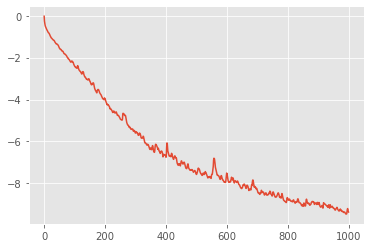

In [33]:
history = model.fit(t_xtrain_sc, t_ytrain, epochs=1000,verbose=1,
                    batch_size=int(len(t_xtrain_sc)/4))
plt.plot(history.history['loss'])

In [34]:
preds_lstm  = model.predict(t_xtest_sc)
# pos_lstm = np.sign(preds_lstm)
pos_lstm = preds_lstm
out_lstm = (t_ytest*pos_lstm).mean(axis=1)
print('Return: {}'.format(out_lstm.mean()*252))
print('Vol: {}'.format(out_lstm.std()*np.sqrt(252)))
print('Sharpe: {}'.format(out_lstm.mean()*np.sqrt(252)/out_lstm.std()))

Return: 0.0035060421972612998
Vol: 0.02065535896996003
Sharpe: 0.16974007580116554


-0.001631960103724542


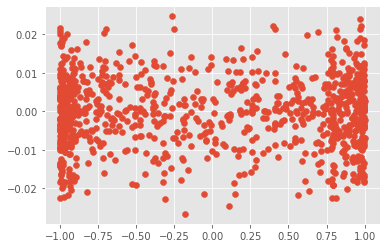

0.036358865783810326


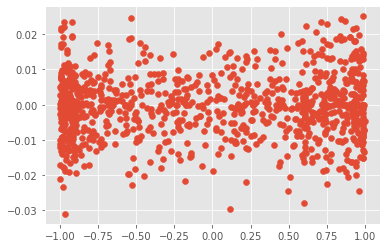

0.015149699725325361


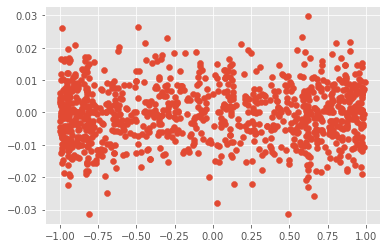

-0.05329677147467233


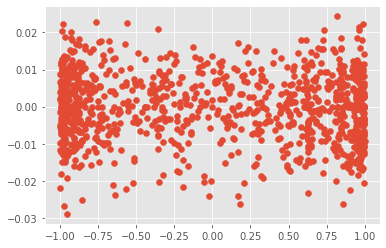

-0.02551210670148705


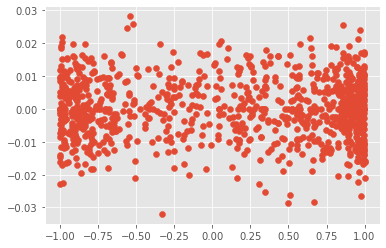

-0.007884675106447527


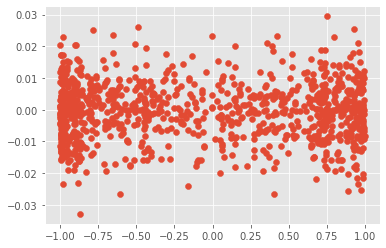

-0.03237976075683259


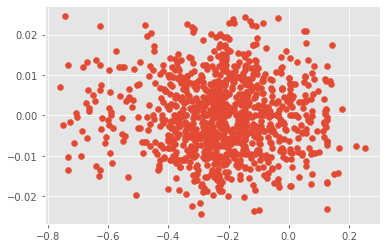

-0.024423097553494352


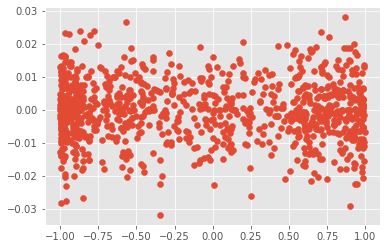

0.016595769998989728


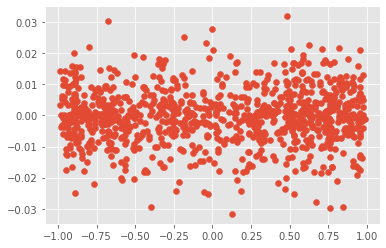

0.002320142320681101


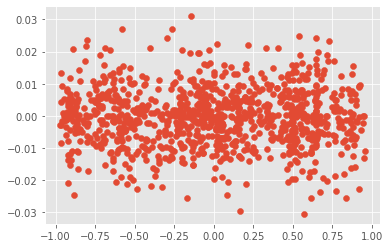

In [141]:
for i in range(10):
    plt.scatter(preds_lstm[:,i],t_ytest[:,i])
    print(np.corrcoef(preds_lstm[:,i],t_ytest[:,i])[0][1])
    plt.show()

In [ ]:
t_xtrain_sc.shape

In [122]:
## callback helper
wt_print = tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs: print(model.layers[0].get_weights()))
term = tf.keras.callbacks.TerminateOnNaN()
checkpoint_filepath = 'tmp'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True)


In [65]:
### SortinoLoss
model = tf.keras.Sequential([
    tf.keras.Input(shape=(num_steps, t_xtrain_sc.shape[2])),
    tf.keras.layers.LSTM(20,dropout=.1,recurrent_dropout=.1),
#     tf.keras.layers.LSTM(10),
    tf.keras.layers.Dense(t_ytrain.shape[1],activation='tanh')
])
model.compile(loss=sortinoLoss, optimizer=tf.optimizers.Adam(learning_rate=.001),
#              run_eagerly=True
             )

Epoch 1/500
5/5 [==============================] - 0s 100ms/step - loss: 7.5490e-05
Epoch 2/500
5/5 [==============================] - 0s 91ms/step - loss: -0.1359
Epoch 3/500
5/5 [==============================] - 0s 95ms/step - loss: -0.1720
Epoch 4/500
5/5 [==============================] - 0s 93ms/step - loss: -0.1911
Epoch 5/500
5/5 [==============================] - 0s 92ms/step - loss: -0.2204
Epoch 6/500
5/5 [==============================] - 0s 96ms/step - loss: -0.2092
Epoch 7/500
5/5 [==============================] - 0s 97ms/step - loss: -0.2270
Epoch 8/500
5/5 [==============================] - 0s 95ms/step - loss: -0.2404
Epoch 9/500
5/5 [==============================] - ETA: 0s - loss: -0.24 - 0s 91ms/step - loss: -0.2471
Epoch 10/500
5/5 [==============================] - 0s 88ms/step - loss: -0.2800
Epoch 11/500
5/5 [==============================] - 0s 88ms/step - loss: -0.2711
Epoch 12/500
5/5 [==============================] - 0s 85ms/step - loss: -0.2585
Epoch 13/

5/5 [==============================] - 0s 49ms/step - loss: -0.2522
Epoch 102/500
5/5 [==============================] - 0s 49ms/step - loss: -0.2484
Epoch 103/500
5/5 [==============================] - 0s 50ms/step - loss: -0.1478
Epoch 104/500
5/5 [==============================] - 0s 50ms/step - loss: -0.2568
Epoch 105/500
5/5 [==============================] - 0s 52ms/step - loss: -0.2354
Epoch 106/500
5/5 [==============================] - 0s 53ms/step - loss: -0.2274
Epoch 107/500
5/5 [==============================] - 0s 59ms/step - loss: -0.2142
Epoch 108/500
5/5 [==============================] - 0s 59ms/step - loss: -0.2137
Epoch 109/500
5/5 [==============================] - 0s 55ms/step - loss: -0.2206
Epoch 110/500
5/5 [==============================] - 0s 58ms/step - loss: -0.2179
Epoch 111/500
5/5 [==============================] - 0s 55ms/step - loss: -0.2261
Epoch 112/500
5/5 [==============================] - 0s 56ms/step - loss: -0.2291
Epoch 113/500
5/5 [===========

5/5 [==============================] - 0s 48ms/step - loss: -0.2893
Epoch 202/500
5/5 [==============================] - 0s 50ms/step - loss: -0.2897
Epoch 203/500
5/5 [==============================] - 0s 51ms/step - loss: -0.3099
Epoch 204/500
5/5 [==============================] - 0s 50ms/step - loss: -0.2838
Epoch 205/500
5/5 [==============================] - 0s 48ms/step - loss: -0.3000
Epoch 206/500
5/5 [==============================] - 0s 48ms/step - loss: -0.2852
Epoch 207/500
5/5 [==============================] - 0s 50ms/step - loss: -0.2974
Epoch 208/500
5/5 [==============================] - 0s 49ms/step - loss: -0.2936
Epoch 209/500
5/5 [==============================] - 0s 48ms/step - loss: -0.2880
Epoch 210/500
5/5 [==============================] - 0s 50ms/step - loss: -0.2929
Epoch 211/500
5/5 [==============================] - 0s 48ms/step - loss: -0.2956
Epoch 212/500
5/5 [==============================] - 0s 50ms/step - loss: -0.2984
Epoch 213/500
5/5 [===========

5/5 [==============================] - 0s 47ms/step - loss: -0.3534
Epoch 301/500
5/5 [==============================] - 0s 46ms/step - loss: -0.3439
Epoch 302/500
5/5 [==============================] - 0s 50ms/step - loss: -0.3518
Epoch 303/500
5/5 [==============================] - 0s 50ms/step - loss: -0.3429
Epoch 304/500
5/5 [==============================] - 0s 47ms/step - loss: -0.3584
Epoch 305/500
5/5 [==============================] - 0s 48ms/step - loss: -0.3544
Epoch 306/500
5/5 [==============================] - 0s 46ms/step - loss: -0.3500
Epoch 307/500
5/5 [==============================] - 0s 48ms/step - loss: -0.3545
Epoch 308/500
5/5 [==============================] - 0s 48ms/step - loss: -0.3592
Epoch 309/500
5/5 [==============================] - 0s 48ms/step - loss: -0.3550
Epoch 310/500
5/5 [==============================] - 0s 48ms/step - loss: -0.3534
Epoch 311/500
5/5 [==============================] - 0s 50ms/step - loss: -0.3659
Epoch 312/500
5/5 [===========

5/5 [==============================] - 0s 50ms/step - loss: -0.3239
Epoch 400/500
5/5 [==============================] - 0s 47ms/step - loss: -0.3102
Epoch 401/500
5/5 [==============================] - 0s 46ms/step - loss: -0.3211
Epoch 402/500
5/5 [==============================] - 0s 50ms/step - loss: -0.3157
Epoch 403/500
5/5 [==============================] - 0s 50ms/step - loss: -0.3225
Epoch 404/500
5/5 [==============================] - 0s 47ms/step - loss: -0.3128
Epoch 405/500
5/5 [==============================] - 0s 48ms/step - loss: -0.2331
Epoch 406/500
5/5 [==============================] - 0s 48ms/step - loss: -0.3185
Epoch 407/500
5/5 [==============================] - 0s 50ms/step - loss: -0.3113
Epoch 408/500
5/5 [==============================] - 0s 49ms/step - loss: -0.3146
Epoch 409/500
5/5 [==============================] - 0s 47ms/step - loss: -0.3137
Epoch 410/500
5/5 [==============================] - 0s 46ms/step - loss: -0.3074
Epoch 411/500
5/5 [===========

5/5 [==============================] - 0s 50ms/step - loss: -0.3167
Epoch 499/500
5/5 [==============================] - 0s 49ms/step - loss: -0.3161
Epoch 500/500
5/5 [==============================] - 0s 47ms/step - loss: -0.3088


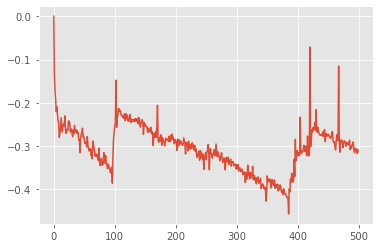

In [66]:
history = model.fit(t_xtrain_sc, t_ytrain, epochs=500,verbose=1,
                   batch_size=int(len(t_xtrain_sc)/4),
#                    callbacks= [model_checkpoint_callback],
                   )
plt.plot(history.history['loss'])

In [63]:
preds_lstm  = model.predict(t_xtest_sc)
# pos_lstm = np.sign(preds_lstm)
pos_lstm = preds_lstm
out_lstm = (t_ytest*pos_lstm).mean(axis=1)
print('Return: {}'.format(out_lstm.mean()*252))
print('Vol: {}'.format(out_lstm.std()*np.sqrt(252)))
print('Sharpe: {}'.format(out_lstm.mean()*np.sqrt(252)/out_lstm.std()))

Return: -0.0035496849236109815
Vol: 0.007266778643837605
Sharpe: -0.48848122360534485


In [129]:
preds_lstm  = model.predict(t_xtrain_sc)
# pos_lstm = np.sign(preds_lstm)
pos_lstm = preds_lstm
out_lstm = (t_ytrain*pos_lstm).mean(axis=1)
print('Return: {}'.format(out_lstm.mean()*252))
print('Vol: {}'.format(out_lstm.std()*np.sqrt(252)))
print('Sharpe: {}'.format(out_lstm.mean()*np.sqrt(252)/out_lstm.std()))

Return: 0.0016537940972044275
Vol: 0.006842128924074278
Sharpe: 0.24170753219593588


0.0015574680088358882


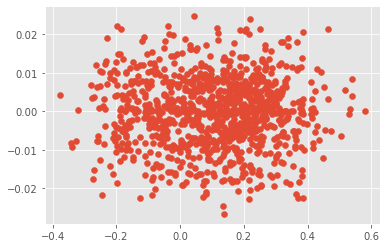

-0.01942823730563652


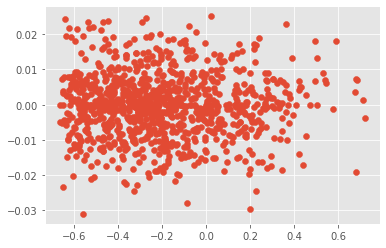

-0.01327255847841162


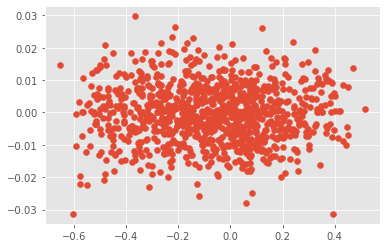

-0.027493095315441144


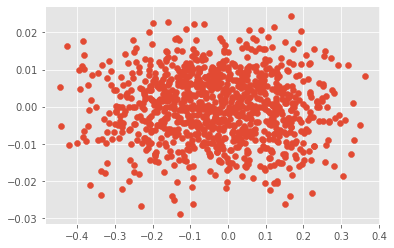

0.004299986462529858


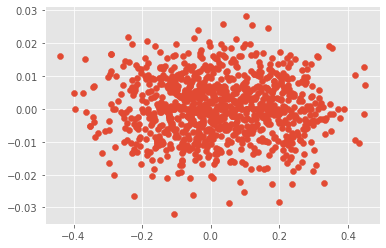

0.00535079589014628


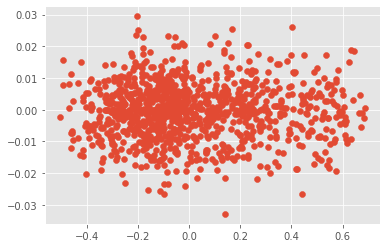

-0.027997230000490037


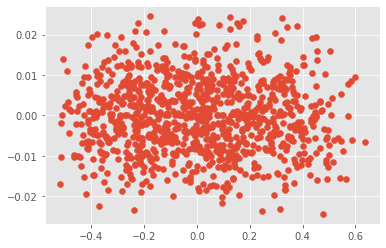

0.011063060748914557


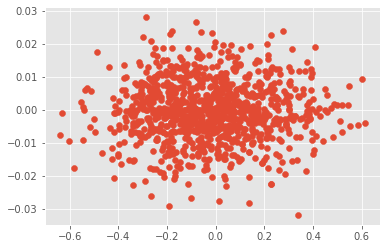

0.014434993816494376


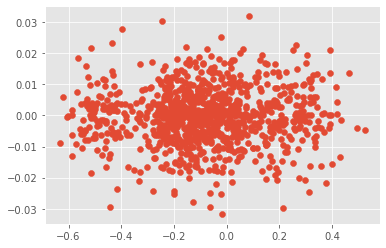

-0.024226628095869486


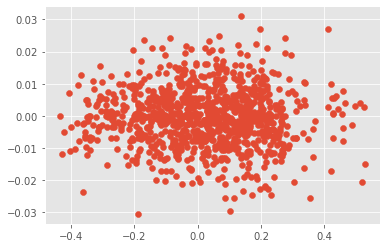

In [62]:
for i in range(10):
    plt.scatter(preds_lstm[:,i],t_ytest[:,i])
    print(np.corrcoef(preds_lstm[:,i],t_ytest[:,i])[0][1])
    plt.show()

In [57]:
cs=[np.corrcoef(preds_lstm[:,i],t_ytest[:,i])[0][1] for i in range(t_ytest.shape[1])]

# Try constraining downside vol

In [161]:
### Adj. Sharpe Loss
model = tf.keras.Sequential([
    tf.keras.Input(shape=(num_steps, t_xtrain_sc.shape[2])),
    tf.keras.layers.LSTM(20,dropout=.2,recurrent_dropout=.2),
#     tf.keras.layers.LSTM(20),
    tf.keras.layers.Dense(t_ytrain.shape[1],activation='tanh')
])
model.compile(loss=adj_sortinoLoss, optimizer=tf.optimizers.Adam(learning_rate=.001))

Epoch 1/600
6/6 [==============================] - 0s 83ms/step - loss: 0.0042
Epoch 2/600
6/6 [==============================] - 1s 84ms/step - loss: -0.1243
Epoch 3/600
6/6 [==============================] - 0s 82ms/step - loss: -0.2033
Epoch 4/600
6/6 [==============================] - 1s 86ms/step - loss: -0.2283
Epoch 5/600
6/6 [==============================] - 0s 82ms/step - loss: -0.2561
Epoch 6/600
6/6 [==============================] - 1s 83ms/step - loss: -0.2900
Epoch 7/600
6/6 [==============================] - 0s 81ms/step - loss: -0.3014
Epoch 8/600
6/6 [==============================] - 1s 85ms/step - loss: -0.3608
Epoch 9/600
6/6 [==============================] - 0s 82ms/step - loss: -0.3411
Epoch 10/600
6/6 [==============================] - 0s 82ms/step - loss: -0.3934
Epoch 11/600
6/6 [==============================] - 0s 82ms/step - loss: -0.3990
Epoch 12/600
6/6 [==============================] - 1s 85ms/step - loss: -0.4145
Epoch 13/600
6/6 [====================

6/6 [==============================] - 0s 82ms/step - loss: -0.9299
Epoch 103/600
6/6 [==============================] - 0s 82ms/step - loss: -0.9412
Epoch 104/600
6/6 [==============================] - 1s 85ms/step - loss: -0.9233
Epoch 105/600
6/6 [==============================] - 0s 83ms/step - loss: -0.9532
Epoch 106/600
6/6 [==============================] - 0s 83ms/step - loss: -0.9327
Epoch 107/600
6/6 [==============================] - 1s 83ms/step - loss: -0.9243
Epoch 108/600
6/6 [==============================] - 0s 82ms/step - loss: -0.9131
Epoch 109/600
6/6 [==============================] - 1s 85ms/step - loss: -0.9506
Epoch 110/600
6/6 [==============================] - 1s 85ms/step - loss: -0.9379
Epoch 111/600
6/6 [==============================] - 1s 85ms/step - loss: -0.9451
Epoch 112/600
6/6 [==============================] - 1s 85ms/step - loss: -0.9301
Epoch 113/600
6/6 [==============================] - 0s 83ms/step - loss: -0.9685
Epoch 114/600
6/6 [===========

6/6 [==============================] - 1s 95ms/step - loss: -1.2326
Epoch 202/600
6/6 [==============================] - 1s 93ms/step - loss: -1.2198
Epoch 203/600
6/6 [==============================] - 1s 88ms/step - loss: -1.2041
Epoch 204/600
6/6 [==============================] - 1s 91ms/step - loss: -1.2118
Epoch 205/600
6/6 [==============================] - 1s 98ms/step - loss: -1.2411
Epoch 206/600
6/6 [==============================] - 1s 88ms/step - loss: -1.2164
Epoch 207/600
6/6 [==============================] - 1s 94ms/step - loss: -1.2229
Epoch 208/600
6/6 [==============================] - 1s 91ms/step - loss: -1.2393
Epoch 209/600
6/6 [==============================] - 1s 87ms/step - loss: -1.2371
Epoch 210/600
6/6 [==============================] - 1s 91ms/step - loss: -1.2484
Epoch 211/600
6/6 [==============================] - 1s 86ms/step - loss: -1.2611
Epoch 212/600
6/6 [==============================] - 1s 90ms/step - loss: -1.2424
Epoch 213/600
6/6 [===========

6/6 [==============================] - 0s 81ms/step - loss: -1.3936
Epoch 302/600
6/6 [==============================] - 1s 86ms/step - loss: -1.3498
Epoch 303/600
6/6 [==============================] - 0s 82ms/step - loss: -1.3773
Epoch 304/600
6/6 [==============================] - 1s 88ms/step - loss: -1.4112
Epoch 305/600
6/6 [==============================] - 0s 82ms/step - loss: -1.3980
Epoch 306/600
6/6 [==============================] - 0s 81ms/step - loss: -1.3861
Epoch 307/600
6/6 [==============================] - 0s 82ms/step - loss: -1.4159
Epoch 308/600
6/6 [==============================] - 1s 88ms/step - loss: -1.4104
Epoch 309/600
6/6 [==============================] - 0s 83ms/step - loss: -1.4259
Epoch 310/600
6/6 [==============================] - 0s 82ms/step - loss: -1.4067
Epoch 311/600
6/6 [==============================] - 0s 81ms/step - loss: -1.4232
Epoch 312/600
6/6 [==============================] - 0s 83ms/step - loss: -1.4636
Epoch 313/600
6/6 [===========

6/6 [==============================] - 1s 114ms/step - loss: -1.5662
Epoch 402/600
6/6 [==============================] - 1s 101ms/step - loss: -1.5424
Epoch 403/600
6/6 [==============================] - 1s 101ms/step - loss: -1.5554
Epoch 404/600
6/6 [==============================] - 1s 97ms/step - loss: -1.5983 0s - loss: -1.59
Epoch 405/600
6/6 [==============================] - 1s 102ms/step - loss: -1.5804
Epoch 406/600
6/6 [==============================] - 1s 105ms/step - loss: -1.5651
Epoch 407/600
6/6 [==============================] - 1s 93ms/step - loss: -1.5933
Epoch 408/600
6/6 [==============================] - 1s 97ms/step - loss: -1.5956
Epoch 409/600
6/6 [==============================] - 1s 101ms/step - loss: -1.5992
Epoch 410/600
6/6 [==============================] - 1s 93ms/step - loss: -1.5837
Epoch 411/600
6/6 [==============================] - 1s 98ms/step - loss: -1.5704
Epoch 412/600
6/6 [==============================] - 1s 97ms/step - loss: -1.6083
Epoch 4

6/6 [==============================] - 1s 83ms/step - loss: -1.7460
Epoch 501/600
6/6 [==============================] - 0s 83ms/step - loss: -1.7580
Epoch 502/600
6/6 [==============================] - 0s 80ms/step - loss: -1.7141
Epoch 503/600
6/6 [==============================] - 0s 82ms/step - loss: -1.7764
Epoch 504/600
6/6 [==============================] - 1s 83ms/step - loss: -1.7876
Epoch 505/600
6/6 [==============================] - 1s 86ms/step - loss: -1.7598
Epoch 506/600
6/6 [==============================] - 0s 82ms/step - loss: -1.7710
Epoch 507/600
6/6 [==============================] - 0s 82ms/step - loss: -1.7743
Epoch 508/600
6/6 [==============================] - 0s 82ms/step - loss: -1.7816
Epoch 509/600
6/6 [==============================] - 1s 84ms/step - loss: -1.7778
Epoch 510/600
6/6 [==============================] - 0s 81ms/step - loss: -1.7888
Epoch 511/600
6/6 [==============================] - 1s 88ms/step - loss: -1.7443
Epoch 512/600
6/6 [===========

6/6 [==============================] - 1s 84ms/step - loss: -1.8003


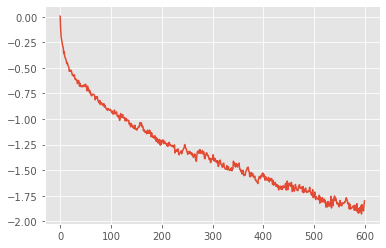

In [162]:
history = model.fit(t_xtrain_sc, t_ytrain, epochs=600,verbose=1,
                    batch_size=int(len(t_xtrain_sc)/5))
plt.plot(history.history['loss'])

In [166]:
preds_lstm  = model.predict(t_xtrain_sc)
# pos_lstm = np.sign(preds_lstm)
pos_lstm = preds_lstm
out_lstm = (t_ytrain*pos_lstm).mean(axis=1)
print('Return: {}'.format(out_lstm.mean()*252))
print('Vol: {}'.format(out_lstm.std()*np.sqrt(252)))
print('Sharpe: {}'.format(out_lstm.mean()*np.sqrt(252)/out_lstm.std()))
print('Sortino: {}'.format(np.maximum(out_lstm,0.0).std()*np.sqrt(252)))

Return: 0.32205454639784026
Vol: 0.011535571053658298
Sharpe: 27.918387819708897
Sortino: 0.009894459879587342


In [168]:
model.save('good_adj_sortino_dropouts')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: good_adj_sortino_dropouts\assets


In [151]:
# in sample sharpe 28.5

In [164]:
preds_lstm  = model.predict(t_xtest_sc)
# pos_lstm = np.sign(preds_lstm)
pos_lstm = preds_lstm
out_lstm = (t_ytest*pos_lstm).mean(axis=1)
print('Return: {}'.format(out_lstm.mean()*252))
print('Vol: {}'.format(out_lstm.std()*np.sqrt(252)))
print('Sharpe: {}'.format(out_lstm.mean()*np.sqrt(252)/out_lstm.std()))
print('Sortino: {}'.format(np.maximum(out_lstm,0.0).std()*np.sqrt(252)))

Return: 0.02551021753500819
Vol: 0.02203021654128099
Sharpe: 1.157964901852247
Sortino: 0.01346568676988544


In [143]:
preds_lstm  = model.predict(t_xtest_sc)
# pos_lstm = np.sign(preds_lstm)
pos_lstm = preds_lstm
out_lstm = (t_ytest*pos_lstm).mean(axis=1)
print('Return: {}'.format(out_lstm.mean()*252))
print('Vol: {}'.format(out_lstm.std()*np.sqrt(252)))
print('Sharpe: {}'.format(out_lstm.mean()*np.sqrt(252)/out_lstm.std()))
print('Sortino: {}'.format(np.maximum(out_lstm,0.0).std()*np.sqrt(252)))

Return: -0.004500146808288652
Vol: 0.02339350501457019
Sharpe: -0.19236736032013263
Sortino: 0.014500534056519078


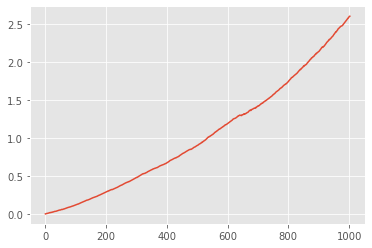

In [167]:
plt.plot((out_lstm + 1).cumprod()-1)

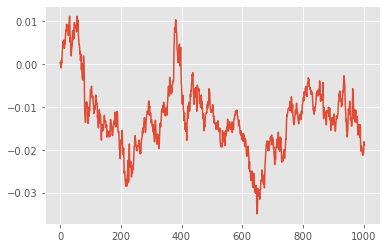

In [142]:
plt.plot((out_lstm + 1).cumprod()-1)

# Figure out multiasset custom loss

In [22]:
xs = tf.random.uniform(minval=-1, maxval=1, shape=(10, 5), dtype=tf.float32)
ys = tf.random.normal(mean=1,shape=(10, 5), dtype=tf.float32)

In [135]:
def batchLoss(yTrue,yPred):
    return -K.mean(yPred*yTrue)/(K.std(yPred*yTrue))

def returnsLoss(yTrue,yPred):
    return -K.mean(yPred*yTrue)

def sharpeLoss(yTrue,yPred):
    u = K.mean(yPred*yTrue)
    n = -u*np.sqrt(252)
    d = (K.sqrt(K.mean((yPred*yTrue)**2)-(u**2)))
    
    return n/d

def adj_sharpeLoss(yTrue,yPred):
    u = K.mean(yPred*yTrue)
    n = -u*np.sqrt(252)
    d = (K.sqrt(K.mean((yPred*yTrue)**2)-(u**2)))
    
    return n/K.maximum(d,.02/np.sqrt(252))

def sortinoLoss(yTrue,yPred):
    u = K.mean(yPred*yTrue,axis=1)
    ix = K.less_equal(u,0)
    n = -K.mean(u)
    
    d = K.std(K.maximum(u,0.0))
    
#     d = tf.where(ix,K.pow(u,2),np.array([10.0]))
#     d = K.sqrt(d)
#     d = K.mean(d)
#     d = 1.0
#     d = K.maximum(d,np.array([1e-4]))
    
    out = tf.math.divide_no_nan(n,d)
    
#     if tf.math.is_nan(out) == True:
#         out = K.zeros_like(out)
        
    return out

def adj_sortinoLoss(yTrue,yPred):
    u = K.mean(yPred*yTrue,axis=1)
    ix = K.less_equal(u,0)
    n = -K.mean(u)
    
    d = K.std(K.maximum(u,0.0))
    
    out = tf.math.divide_no_nan(n,K.maximum(d,.01/np.sqrt(252)))
    
#     if tf.math.is_nan(out) == True:
#         out = K.zeros_like(out)
        
    return out
    

In [108]:
sharpeLoss(xs,ys)

<tf.Tensor: shape=(), dtype=float32, numpy=-2.673918>

In [109]:
sortinoLoss(xs,ys)

<tf.Tensor: shape=(), dtype=float32, numpy=-0.5301003>

In [110]:
adj_sharpeLoss(xs,ys)

<tf.Tensor: shape=(), dtype=float32, numpy=-2.673918>

In [111]:
adj_sortinoLoss(xs,ys)

<tf.Tensor: shape=(), dtype=float32, numpy=-0.5301003>

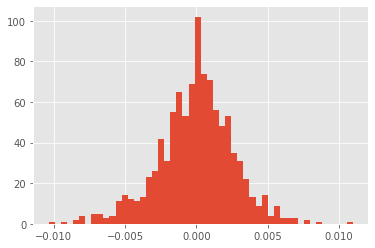

In [123]:
plt.hist(out_lstm,bins=50);